In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import requests
import zipfile
from io import BytesIO
from io import StringIO
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import time

from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler

2023-04-30 16:40:04.695494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:


# Load and preprocess the datasets
def load_and_preprocess_parkinsons():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data'
    df = pd.read_csv(url)
    df = df.drop(['subject#'], axis=1)
    X = df.drop(['motor_UPDRS', 'total_UPDRS'], axis=1).values
    y = df['total_UPDRS'].values
    return X, y

def load_and_preprocess_energy():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
    df = pd.read_excel(url)
    X = df.drop(['Y1', 'Y2'], axis=1).values
    y = df['Y1'].values
    return X, y


def load_and_preprocess_superconductivity():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00464/superconduct.zip'
    response = requests.get(url)
    zf = zipfile.ZipFile(BytesIO(response.content))
    df = pd.read_csv(zf.open('train.csv'))
    X = df.drop(['critical_temp'], axis=1).values
    y = df['critical_temp'].values
    return X, y

def load_and_preprocess_forest_fires():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'
    df = pd.read_csv(url)
    df = pd.get_dummies(df)
    X = df.drop(['area'], axis=1).values
    y = df['area'].values
    return X, y

def load_and_preprocess_wine_quality():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    df = pd.read_csv(url, delimiter=';')
    X = df.drop(['quality'], axis=1).values
    y = df['quality'].values
    return X, y

X_parkinsons, y_parkinsons = load_and_preprocess_parkinsons()
X_energy, y_energy = load_and_preprocess_energy()
X_superconductivity, y_superconductivity = load_and_preprocess_superconductivity()
# X_forest_fires, y_forest_fires = load_and_preprocess_forest_fires()
X_wine_quality, y_wine_quality = load_and_preprocess_wine_quality()

# Scale the datasets
scaler_parkinsons = StandardScaler().fit(X_parkinsons)
scaler_energy = StandardScaler().fit(X_energy)
scaler_superconductivity = StandardScaler().fit(X_superconductivity)
# scaler_forest_fires = StandardScaler().fit(X_forest_fires)
scaler_wine_quality = StandardScaler().fit(X_wine_quality)

X_parkinsons_scaled = scaler_parkinsons.transform(X_parkinsons)
X_energy_scaled = scaler_energy.transform(X_energy)
X_superconductivity_scaled = scaler_superconductivity.transform(X_superconductivity)
# X_forest_fires_scaled = scaler_forest_fires.transform(X_forest_fires)
X_wine_quality_scaled = scaler_wine_quality.transform(X_wine_quality)

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

datasets_reg = {
    'Parkinsons': (X_parkinsons_scaled, y_parkinsons),
    'Energy Efficiency': (X_energy_scaled, y_energy),
    'Superconductivity': (X_superconductivity_scaled, y_superconductivity),
    # 'Forest Fires': (X_forest_fires_scaled, y_forest_fires),
    'Wine Quality': (X_wine_quality_scaled, y_wine_quality)
}

def plot_training_time(datasets, dataset_name):
    dataset_names = list(datasets.keys())
    model_names = list(datasets[dataset_names[0]].keys())

    training_times = []
    for name in dataset_names:
        if name == dataset_name:
            training_times.append([datasets[name][model_name]['elapsed_time'] for model_name in model_names])

    df = pd.DataFrame(training_times, columns=model_names, index=[dataset_name])
    sns.barplot(data=df, errorbar=None)
    plt.xlabel('Datasets')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time for Models')
    plt.xticks(rotation=45)
    plt.show()

def plot_mse(datasets, dataset_name):
    dataset_names = list(datasets.keys())
    model_names = list(datasets[dataset_names[0]].keys())

    mse_values = []
    for name in dataset_names:
        if name == dataset_name:
            mse_values.append([datasets[name][model_name]['test_mse'] for model_name in model_names])

    df = pd.DataFrame(mse_values, columns=model_names, index=[dataset_name])
    sns.barplot(data=df, errorbar=None)
    plt.xlabel('Datasets')
    plt.ylabel('MSE')
    plt.title('MSE for Models')
    plt.xticks(rotation=45)
    plt.show()

def plot_accuracy(datasets):
    dataset_names = list(datasets.keys())
    model_names = list(datasets[dataset_names[0]].keys())

    accuracy_values = []
    for dataset_name in dataset_names:
        accuracy_values.append([datasets[dataset_name][model_name]['accuracy'] for model_name in model_names])

    df = pd.DataFrame(accuracy_values, columns=model_names, index=dataset_names)
    sns.barplot(data=df, errorbar=None)
    plt.xlabel('Datasets')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Models')
    plt.xticks(rotation=45)
    plt.show()

def plot_mape(datasets, dataset_name):
    dataset_names = list(datasets.keys())
    model_names = list(datasets[dataset_names[0]].keys())

    mape_values = []
    for name in dataset_names:
        if name == dataset_name:
            mape_values.append([datasets[name][model_name]['test_r2'] for model_name in model_names])

    df = pd.DataFrame(mape_values, columns=model_names, index=[dataset_name])
    sns.barplot(data=df, errorbar=None)
    plt.xlabel('Datasets')
    plt.ylabel('R2')
    plt.title('R2 for Models')
    plt.xticks(rotation=45)
    plt.show()



In [5]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from tqdm import tqdm

def build_neural_network(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def fit_and_predict_model(name, model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    y_pred_test = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    return name, {
        'test_mse': test_error,
        'test_r2': test_r2,
        'elapsed_time': elapsed_time
    }

def run_regression(X, y, random_state=42, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    regression_models = [
        ('Lasso', Lasso(alpha=0.1)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=random_state)),
        ('XGBoost', XGBRegressor(n_estimators=100, random_state=random_state)),
        ('SVR', SVR(kernel='linear')),
        ('k-NN', KNeighborsRegressor(n_neighbors=5)),
        ('AdaBoost', AdaBoostRegressor(n_estimators=100, random_state=random_state)),
        ('ExtraTrees', ExtraTreesRegressor(n_estimators=100, random_state=random_state)),
        ('NeuralNetwork', KerasRegressor(build_fn=build_neural_network, input_dim=X.shape[1], epochs=100, batch_size=32, verbose=0))
    ]

    return results

In [6]:
all_results = {}

for dataset_name, (X, y) in datasets_reg.items():
    print(f"\n{dataset_name}:")
    results = run_regression(X, y)
    all_results[dataset_name] = results
    for model_name, metrics in results.items():
        print(f"{model_name}: Test MSE: {metrics['test_mse']:.4f}, Test R2: {metrics['test_r2']:.4f}")


Parkinsons:


/var/folders/vb/817xcbhj4192m8bd4yqqr0h00000gn/T/ipykernel_55320/956307361.py:49: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('NeuralNetwork', KerasRegressor(build_fn=build_neural_network, input_dim=X.shape[1], epochs=100, batch_size=32, verbose=0))
2023-04-30 15:17:32.826456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 8/8 [00:25<00:00,  3.19s/it]
/var/folders/vb/817xcbhj4192m8bd4yqqr0h00000gn/T/ipykernel_55320/956307361.py:49: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.a

Lasso: Test MSE: 93.4615, Test R2: 0.1566
k-NN: Test MSE: 39.4418, Test R2: 0.6441
XGBoost: Test MSE: 4.8244, Test R2: 0.9565
SVR: Test MSE: 96.6305, Test R2: 0.1280
ExtraTrees: Test MSE: 2.2313, Test R2: 0.9799
AdaBoost: Test MSE: 69.1746, Test R2: 0.3758
RandomForest: Test MSE: 2.5748, Test R2: 0.9768
NeuralNetwork: Test MSE: 26.9666, Test R2: 0.7566

Energy Efficiency:


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
/var/folders/vb/817xcbhj4192m8bd4yqqr0h00000gn/T/ipykernel_55320/956307361.py:49: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('NeuralNetwork', KerasRegressor(build_fn=build_neural_network, input_dim=X.shape[1], epochs=100, batch_size=32, verbose=0))


SVR: Test MSE: 9.7768, Test R2: 0.9062
k-NN: Test MSE: 5.3575, Test R2: 0.9486
Lasso: Test MSE: 9.9394, Test R2: 0.9046
AdaBoost: Test MSE: 4.0551, Test R2: 0.9611
XGBoost: Test MSE: 0.1442, Test R2: 0.9986
ExtraTrees: Test MSE: 0.2564, Test R2: 0.9975
RandomForest: Test MSE: 0.2444, Test R2: 0.9977
NeuralNetwork: Test MSE: 2.6743, Test R2: 0.9743

Superconductivity:


100%|██████████| 8/8 [01:58<00:00, 14.80s/it]
/var/folders/vb/817xcbhj4192m8bd4yqqr0h00000gn/T/ipykernel_55320/956307361.py:49: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('NeuralNetwork', KerasRegressor(build_fn=build_neural_network, input_dim=X.shape[1], epochs=100, batch_size=32, verbose=0))


k-NN: Test MSE: 108.9181, Test R2: 0.9054
XGBoost: Test MSE: 89.1691, Test R2: 0.9225
Lasso: Test MSE: 328.8063, Test R2: 0.7143
AdaBoost: Test MSE: 408.6658, Test R2: 0.6450
ExtraTrees: Test MSE: 78.7690, Test R2: 0.9316
SVR: Test MSE: 321.2115, Test R2: 0.7209
NeuralNetwork: Test MSE: 120.5678, Test R2: 0.8953
RandomForest: Test MSE: 81.4574, Test R2: 0.9292

Wine Quality:


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]

Lasso: Test MSE: 0.4389, Test R2: 0.3284
k-NN: Test MSE: 0.4386, Test R2: 0.3288
SVR: Test MSE: 0.3966, Test R2: 0.3931
XGBoost: Test MSE: 0.3330, Test R2: 0.4904
AdaBoost: Test MSE: 0.3854, Test R2: 0.4103
ExtraTrees: Test MSE: 0.2926, Test R2: 0.5522
RandomForest: Test MSE: 0.3014, Test R2: 0.5389
NeuralNetwork: Test MSE: 0.4368, Test R2: 0.3315


100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


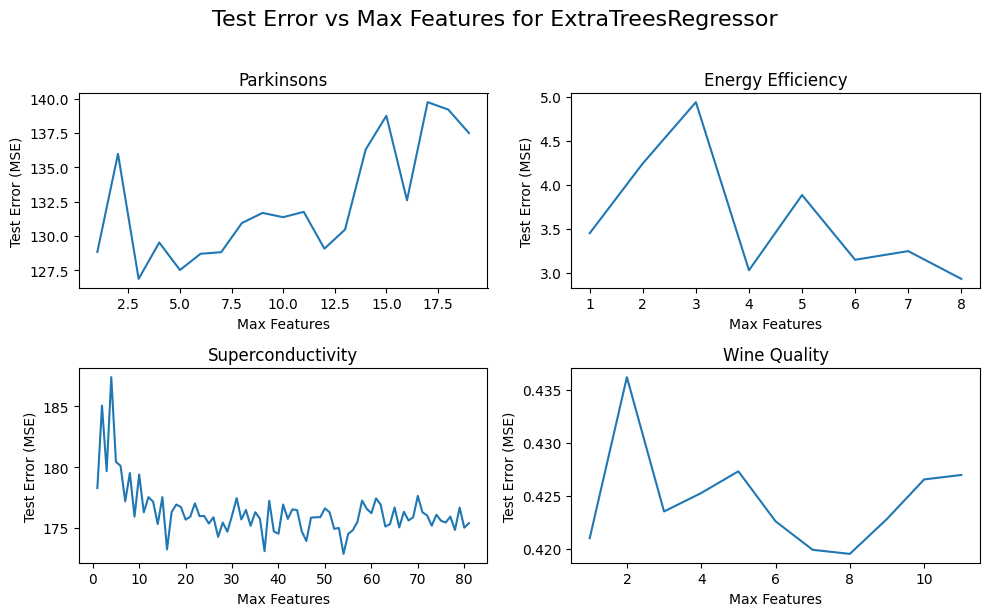

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

# Your dataset loading and scaling code goes here...

def calculate_error(max_features, X, y):
    reg = ExtraTreesRegressor(max_features=max_features, random_state=42, n_jobs=-1)
    scores = cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error')
    return -np.mean(scores)

def test_error_vs_max_features(X, y):
    max_features_range = np.arange(1, X.shape[1] + 1)

# Create a figure
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.ravel()

# Plot test error vs max_features for each dataset
for i, (dataset_name, (X, y)) in enumerate(datasets_reg.items()):
    max_features_range, errors = test_error_vs_max_features(X, y)
    axes[i].plot(max_features_range, errors)
    axes[i].set_xlabel('Max Features')
    axes[i].set_ylabel('Test Error (MSE)')
    axes[i].set_title(dataset_name)

# Remove the extra subplot
# axes[-1].axis('off')

fig.suptitle('Test Error vs Max Features for ExtraTreesRegressor', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


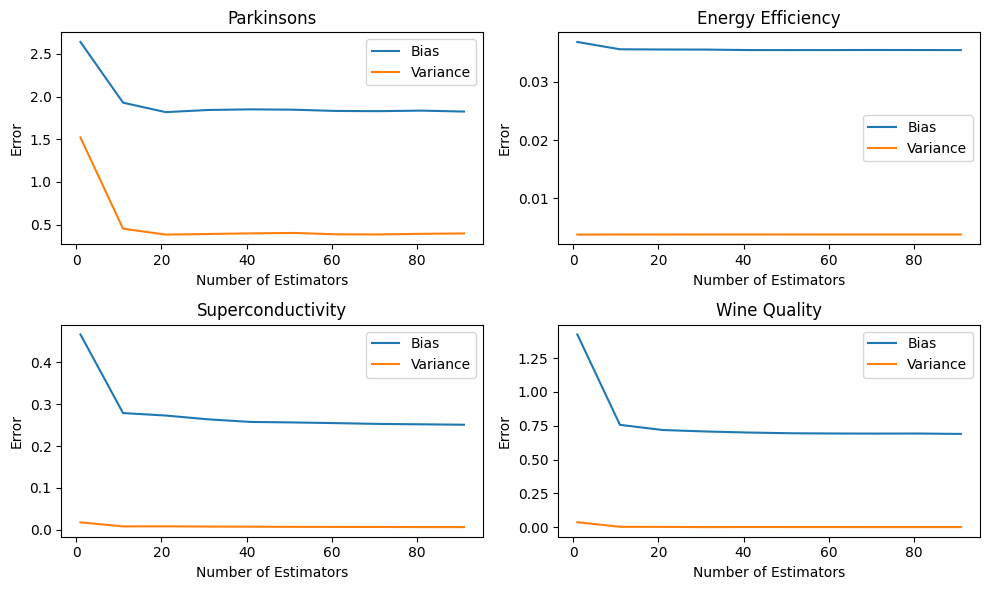

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

# Function to calculate bias and variance
def bias_variance_tradeoff(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    bias = 1 - np.mean(scores)
    variance = np.var(scores)
    return bias, variance

def calculate_bias_variance(n_estimators, X, y):
    model = ExtraTreesRegressor(n_estimators=n_estimators, random_state=42)
    return bias_variance_tradeoff(model, X, y)

fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()

# Loop through datasets and plot the results
for i, (name, data) in enumerate(datasets_reg.items()):
    X, y = data
    biases = []
    variances = []
    n_estimators_range = range(1, 101, 10)

    ax[i].plot(n_estimators_range, biases, label='Bias')
    ax[i].plot(n_estimators_range, variances, label='Variance')
    ax[i].set_title(name)
    ax[i].set_xlabel('Number of Estimators')
    ax[i].set_ylabel('Error')
    ax[i].legend()

#axes[-1].axis('off')

plt.tight_layout()
plt.show()


100%|██████████| 11/11 [00:10<00:00,  1.04it/s]


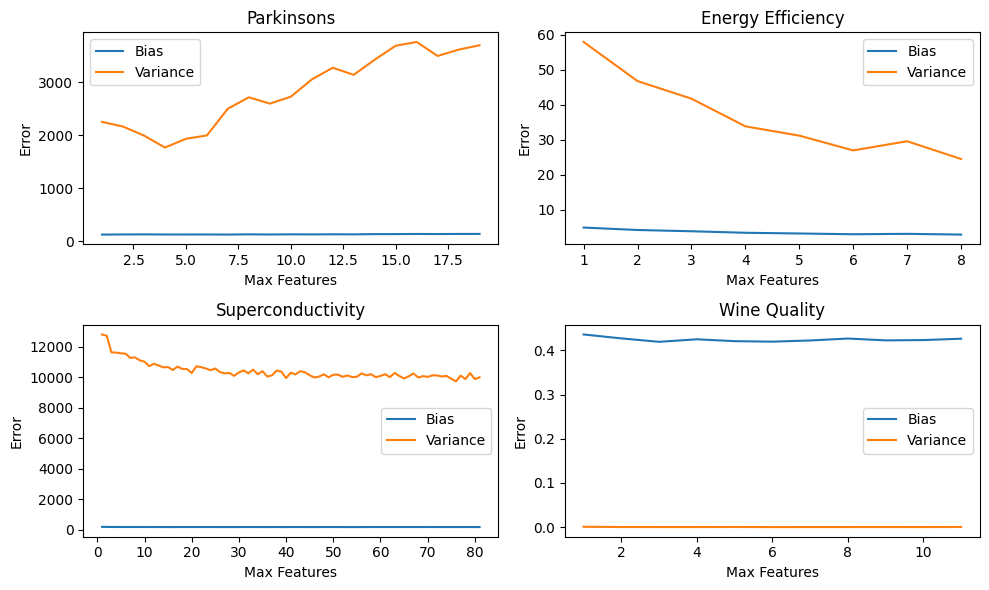

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

def bias_variance_tradeoff_max_features(X, y, max_features):
    model = ExtraTreesRegressor(n_estimators=100, max_features=max_features, random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    bias = -np.mean(scores)
    variance = np.var(scores)
    return max_features, bias, variance

fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()

for i, (name, data) in enumerate(datasets_reg.items()):
    X, y = data
    biases = []
    variances = []
    max_features_range = range(1, X.shape[1] + 1)

    ax[i].plot(max_features_range, biases, label='Bias')
    ax[i].plot(max_features_range, variances, label='Variance')
    ax[i].set_title(name)
    ax[i].set_xlabel('Max Features')
    ax[i].set_ylabel('Error')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [11]:
dataset_names_reg = [
    'Parkinsons',
    'Energy Efficiency',
    'Superconductivity',
    #'Forest Fires',
    'Wine Quality'
]

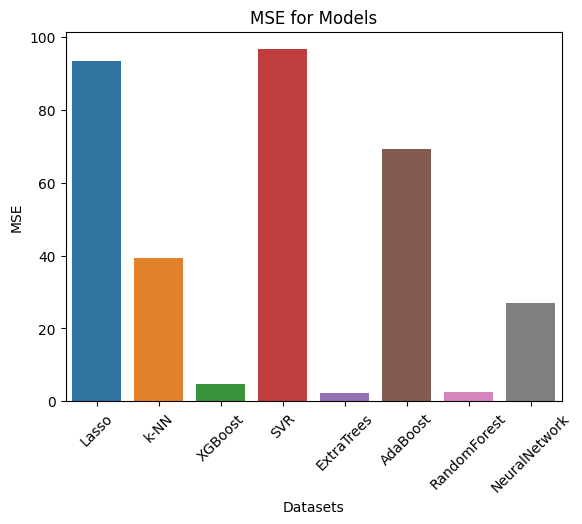

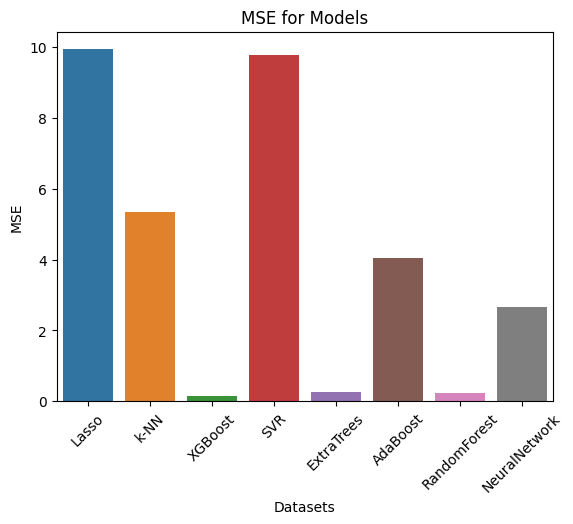

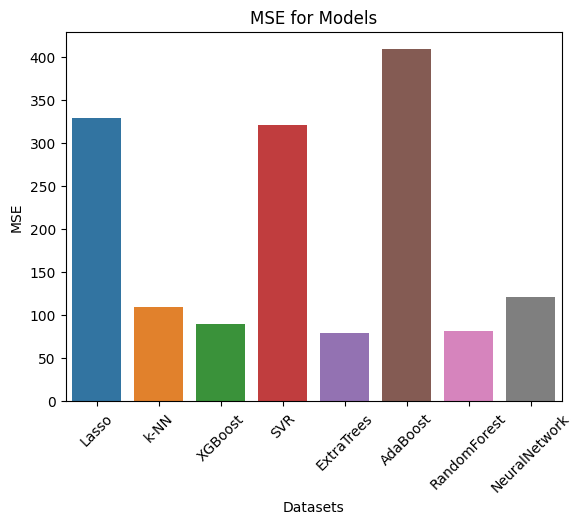

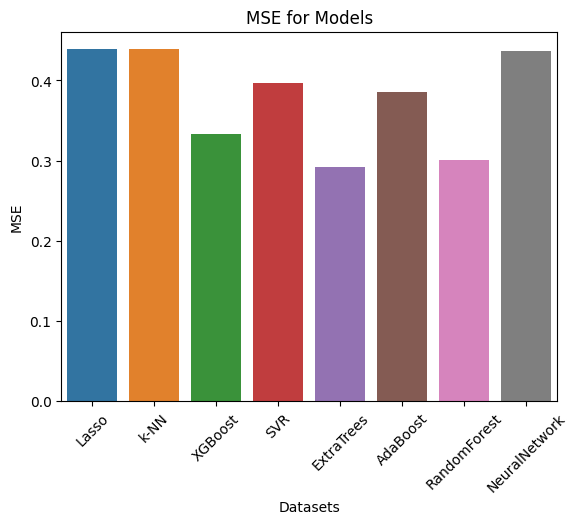

In [12]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_training_time_and_mape(datasets, dataset_name):
    dataset_names = list(datasets.keys())
    model_names = list(datasets[dataset_names[0]].keys())

    training_times = []
    mape_values = []

    for name in dataset_names:
        if name == dataset_name:
            training_times.append([datasets[name][model_name]['elapsed_time'] for model_name in model_names])
            mape_values.append([datasets[name][model_name]['test_r2'] for model_name in model_names])

    fig = make_subplots(rows=1, cols=2, subplot_titles=(f"Training Time ({dataset_name})", f"R2 ({dataset_name})"))

    for i, model_name in enumerate(model_names):
        fig.add_trace(go.Bar(x=[dataset_name], y=[training_times[0][i]], name=model_name), row=1, col=1)
        fig.add_trace(go.Bar(x=[dataset_name], y=[mape_values[0][i]], name=model_name), row=1, col=2)

    fig.update_xaxes(title_text="Datasets", row=1, col=1)
    fig.update_xaxes(title_text="Datasets", row=1, col=2)
    fig.update_yaxes(title_text="Training Time (s)", row=1, col=1)
    fig.update_yaxes(title_text="R2", row=1, col=2)

    fig.update_layout(title=f"{dataset_name} - Training Time and R2", showlegend=True, barmode='group')
    fig.show()

def plot_all_models(datasets, dataset_name, task='regression'):
    plot_training_time_and_mape(datasets, dataset_name)

    if task == 'regression':
        plot_mse(datasets, dataset_name)
    elif task == 'classification':
        plot_accuracy(datasets, dataset_name)

for dataset_name in dataset_names_reg:
    plot_all_models(all_results, dataset_name, task='regression')

# Classfication

In [23]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

def fit_and_predict_classifier(name, classifier, X_train, y_train, X_test, y_test):
    start_time = time.time()
    classifier.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    y_pred_test = classifier.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    accuracy = accuracy_score(y_test, y_pred_test)

    return name, {
        'test_mse': mse,
        'accuracy': accuracy,
        'elapsed_time': elapsed_time
    }

def run_classifiers(X, y, output=None, random_state=42, test_size=0.2, epochs=50, batch_size=16, learning_rate=0.001):
    if output == None:
        output = len(np.unique(y))

    # Encode class labels to be consecutive integers starting from 0
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, random_state=random_state)

    classifiers = [
        ('k-NN', KNeighborsClassifier(n_neighbors=3)),
        ('ExtraTrees', ExtraTreesClassifier(n_estimators=100, random_state=random_state)),
        ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=random_state)),
        ('XGBoost', XGBClassifier(n_estimators=100, random_state=random_state)),
        ('SVC', SVC(kernel='linear', random_state=random_state)),
        ('LDA', LinearDiscriminantAnalysis())
    ]

    # Neural Networks
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(output, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    y_train_categorical = to_categorical(y_train)
    y_test_categorical = to_categorical(y_test)
    start_time = time.time()
    model.fit(X_train, y_train_categorical, epochs=epochs, batch_size=batch_size, verbose=0)
    elapsed_time_neural_network = time.time() - start_time

    y_pred_test_neural_network = np.argmax(model.predict(X_test), axis=1)
    mse_neural_network = mean_squared_error(y_test, y_pred_test_neural_network)
    accuracy_neural_network = accuracy_score(y_test, y_pred_test_neural_network)

    results['neural_network'] = {
        'test_mse': mse_neural_network,
        'accuracy': accuracy_neural_network,
        'elapsed_time': elapsed_time_neural_network
    }
    
    return results

In [24]:
def load_wine_quality():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    data = requests.get(url).text
    df = pd.read_csv(StringIO(data), sep=';')
    X = df.drop('quality', axis=1).values
    y = df['quality'].values
    return X, y


def load_energy_efficiency():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
    df = pd.read_excel(url)
    X = df.drop(['Y1', 'Y2'], axis=1).values
    # Y1 Heating Load
    y = df['Y1'].values
    return X, y


def load_spam():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
    data = requests.get(url).text
    df = pd.read_csv(StringIO(data), header=None)
    X = df.drop(57, axis=1).values
    y = df[57].values
    return X, y


def load_heart_disease():
    # Cleveland Dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
    df = pd.read_csv(url, header=None, na_values='?')
    df = df.dropna()
    X = df.drop(13, axis=1).values
    y = df[13].values
    return X, y

def load_handwritten_digits():
    digits = load_digits()
    df = pd.DataFrame(digits.data, columns=digits.feature_names)
    df['target'] = digits.target

    X = df.drop('target', axis=1).values
    y = df['target'].values
    return X, y




# Load datasets
X_wine, y_wine = load_wine_quality()
X_energy, y_energy = load_energy_efficiency()
X_spam, y_spam = load_spam()
X_heart, y_heart = load_heart_disease()
X_digits, y_digits = load_handwritten_digits()

# Scale datasets
scaler = MinMaxScaler()
X_wine_scaled = scaler.fit_transform(X_wine)
X_energy_scaled = scaler.fit_transform(X_energy)
X_spam_scaled = scaler.fit_transform(X_spam)
X_heart_scaled = scaler.fit_transform(X_heart)
X_digits_scaled = scaler.fit_transform(X_digits)

In [26]:
results_wine = run_classifiers(X_wine_scaled, y_wine)
results_spam = run_classifiers(X_spam_scaled, y_spam)
results_heart = run_classifiers(X_heart_scaled, y_heart)
results_digits = run_classifiers(X_digits_scaled, y_digits)

100%|██████████| 6/6 [00:00<00:00,  6.86it/s]


10/10 [==============================] - 0s 1ms/step


100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


29/29 [==============================] - 0s 1ms/step


100%|██████████| 6/6 [00:00<00:00, 13.89it/s]


2/2 [==============================] - 0s 2ms/step


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


12/12 [==============================] - 0s 1ms/step


In [29]:
results_wine

{'k-NN': {'test_mse': 0.65,
  'accuracy': 0.534375,
  'elapsed_time': 0.0022368431091308594},
 'LDA': {'test_mse': 0.559375,
  'accuracy': 0.559375,
  'elapsed_time': 0.056478023529052734},
 'SVC': {'test_mse': 0.5375,
  'accuracy': 0.546875,
  'elapsed_time': 0.1053168773651123},
 'ExtraTrees': {'test_mse': 0.35,
  'accuracy': 0.6875,
  'elapsed_time': 0.5586111545562744},
 'RandomForest': {'test_mse': 0.39375,
  'accuracy': 0.6625,
  'elapsed_time': 0.6785190105438232},
 'XGBoost': {'test_mse': 0.45,
  'accuracy': 0.678125,
  'elapsed_time': 0.9672560691833496},
 'neural_network': {'test_mse': 0.465625,
  'accuracy': 0.590625,
  'elapsed_time': 5.681909084320068}}

In [30]:
datasets_class = {
    'Wine Quality': results_wine,
    'Spam': results_spam,
    'Heart Disease': results_heart,
    'Handwritten Digits': results_digits
}

models = ['k-NN', 'neural_network', 'ExtraTrees', 'RandomForest', 'XGBoost', 'SVC', 'LDA']

for dataset_name, dataset_results in datasets_class.items():
    print(dataset_name)
    for model_name in models:
        model_results = dataset_results[model_name]
        print(f"{model_name.capitalize()}: MSE: {model_results['test_mse']:.4f}, Accuracy: {model_results['accuracy']:.4f}")
    print()

Wine Quality
K-nn: MSE: 0.6500, Accuracy: 0.5344
Neural_network: MSE: 0.4656, Accuracy: 0.5906
Extratrees: MSE: 0.3500, Accuracy: 0.6875
Randomforest: MSE: 0.3937, Accuracy: 0.6625
Xgboost: MSE: 0.4500, Accuracy: 0.6781
Svc: MSE: 0.5375, Accuracy: 0.5469
Lda: MSE: 0.5594, Accuracy: 0.5594

Spam
K-nn: MSE: 0.1194, Accuracy: 0.8806
Neural_network: MSE: 0.0489, Accuracy: 0.9511
Extratrees: MSE: 0.0413, Accuracy: 0.9587
Randomforest: MSE: 0.0445, Accuracy: 0.9555
Xgboost: MSE: 0.0413, Accuracy: 0.9587
Svc: MSE: 0.1042, Accuracy: 0.8958
Lda: MSE: 0.1183, Accuracy: 0.8817

Heart Disease
K-nn: MSE: 1.3167, Accuracy: 0.6667
Neural_network: MSE: 1.1167, Accuracy: 0.6000
Extratrees: MSE: 1.4333, Accuracy: 0.6500
Randomforest: MSE: 1.1667, Accuracy: 0.6000
Xgboost: MSE: 1.2833, Accuracy: 0.5833
Svc: MSE: 1.3000, Accuracy: 0.6000
Lda: MSE: 1.2667, Accuracy: 0.6333

Handwritten Digits
K-nn: MSE: 0.3639, Accuracy: 0.9833
Neural_network: MSE: 0.2528, Accuracy: 0.9806
Extratrees: MSE: 0.2194, Accuracy

In [33]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_training_time_and_accuracy(datasets, dataset_name):
    dataset_names = list(datasets.keys())
    model_names = list(datasets[dataset_names[0]].keys())

    training_times = []
    accuracy_values = []

    for name in dataset_names:
        if name == dataset_name:
            training_times.append([datasets[name][model_name]['elapsed_time'] for model_name in model_names])
            accuracy_values.append([datasets[name][model_name]['accuracy'] for model_name in model_names])

    fig = make_subplots(rows=1, cols=2, subplot_titles=(f"Training Time ({dataset_name})", f"Accuracy ({dataset_name})"))

    for i, model_name in enumerate(model_names):
        fig.add_trace(go.Bar(x=[dataset_name], y=[training_times[0][i]], name=model_name), row=1, col=1)
        fig.add_trace(go.Bar(x=[dataset_name], y=[accuracy_values[0][i]], name=model_name), row=1, col=2)

    fig.update_xaxes(title_text="Datasets", row=1, col=1)
    fig.update_xaxes(title_text="Datasets", row=1, col=2)
    fig.update_yaxes(title_text="Training Time (s)", row=1, col=1)
    fig.update_yaxes(title_text="Accuracy", row=1, col=2)

    fig.update_layout(title=f"{dataset_name} - Training Time and Accuracy", showlegend=True, barmode='group')
    fig.show()

def plot_all_classifiers(datasets, dataset_name):
    plot_training_time_and_accuracy(datasets, dataset_name)

dataset_names_classification = ['Wine Dataset', 'Spam Dataset', 'Heart Dataset', 'Digits Dataset']
all_results_classification = {
    'Wine Dataset': results_wine,
    'Spam Dataset': results_spam,
    'Heart Dataset': results_heart,
    'Digits Dataset': results_digits
}

for dataset_name in dataset_names_classification:
    plot_all_classifiers(all_results_classification, dataset_name)

100%|██████████| 64/64 [00:12<00:00,  4.93it/s]


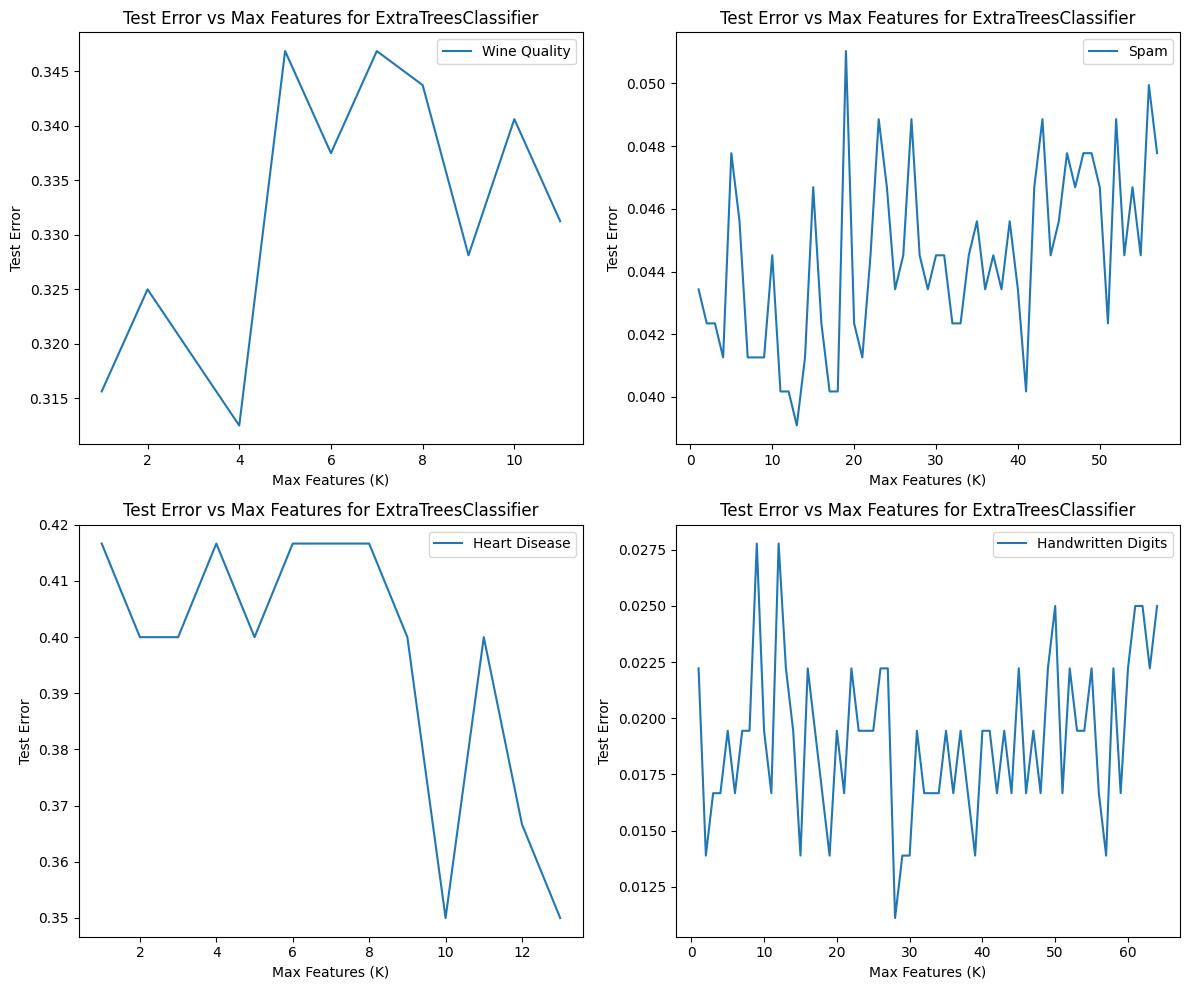

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def test_error_vs_max_features(X, y, max_features):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = ExtraTreesClassifier(max_features=max_features, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    error = 1 - accuracy_score(y_test, y_pred)
    return max_features, error

def plot_test_error_vs_max_features(datasets):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    ax = ax.ravel()

    for i, (name, data) in enumerate(datasets.items()):
        X, y = data
        max_features_range = range(1, X.shape[1] + 1)
        errors = []

        ax[i].plot(max_features_range, errors, label=name)
        ax[i].set_xlabel('Max Features (K)')
        ax[i].set_ylabel('Test Error')
        ax[i].legend()
        ax[i].set_title('Test Error vs Max Features for ExtraTreesClassifier')

    plt.tight_layout()
    plt.show()

datasets_class = {
    'Wine Quality': (X_wine_scaled, y_wine),
    'Spam': (X_spam_scaled, y_spam),
    'Heart Disease': (X_heart_scaled, y_heart),
    'Handwritten Digits': (X_digits_scaled, y_digits)
}

plot_test_error_vs_max_features(datasets_class)

100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


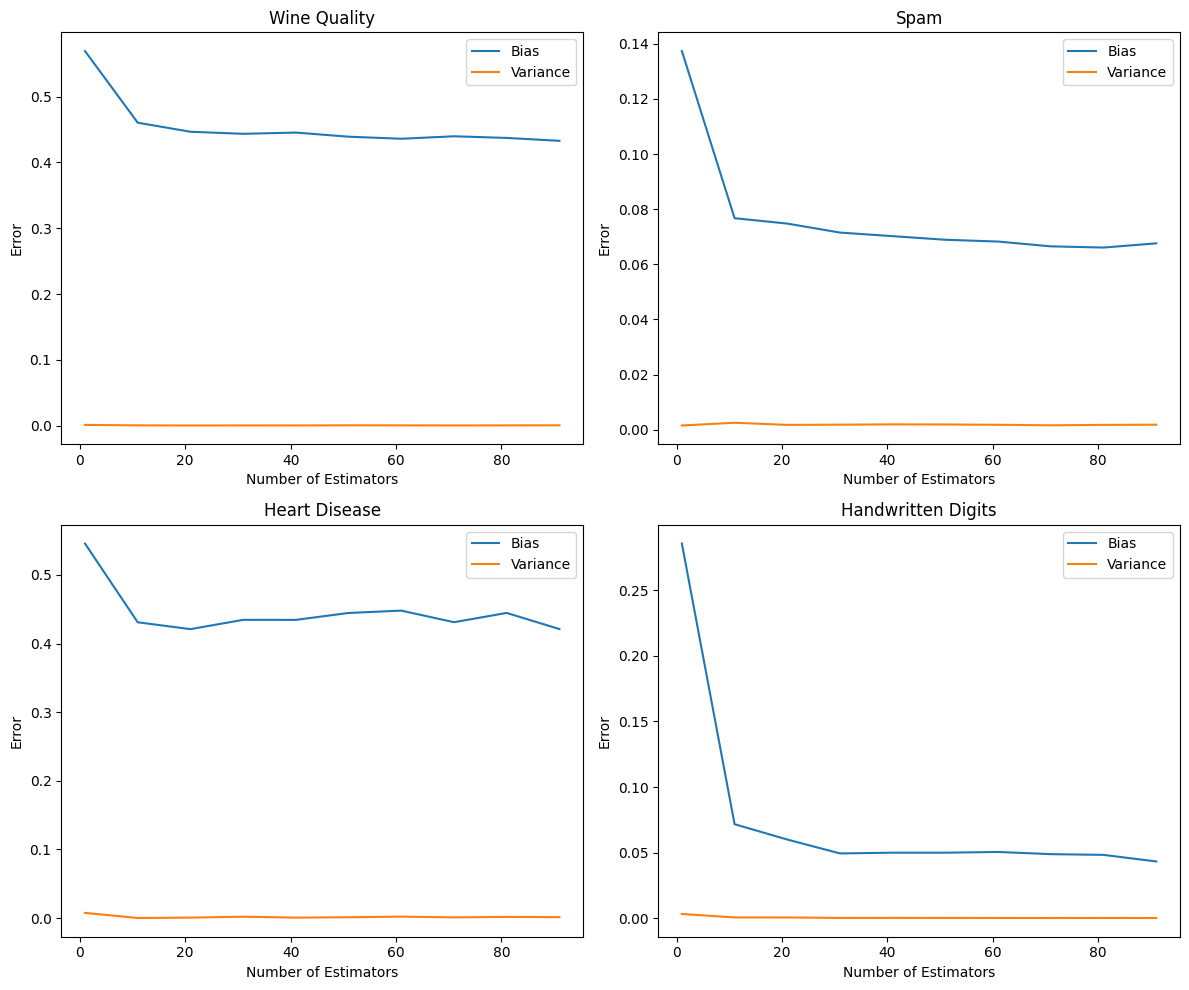

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

def bias_variance_tradeoff(X, y, n_estimators):
    model = ExtraTreesClassifier(n_estimators=n_estimators, random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    bias = 1 - np.mean(scores)
    variance = np.var(scores)
    return n_estimators, bias, variance

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.ravel()

for i, (name, data) in enumerate(datasets_class.items()):
    X, y = data
    biases = []
    variances = []
    n_estimators_range = range(1, 101, 10)

    ax[i].plot(n_estimators_range, biases, label='Bias')
    ax[i].plot(n_estimators_range, variances, label='Variance')
    ax[i].set_title(name)
    ax[i].set_xlabel('Number of Estimators')
    ax[i].set_ylabel('Error')
    ax[i].legend()

plt.tight_layout()
plt.show()

100%|██████████| 64/64 [01:07<00:00,  1.05s/it]


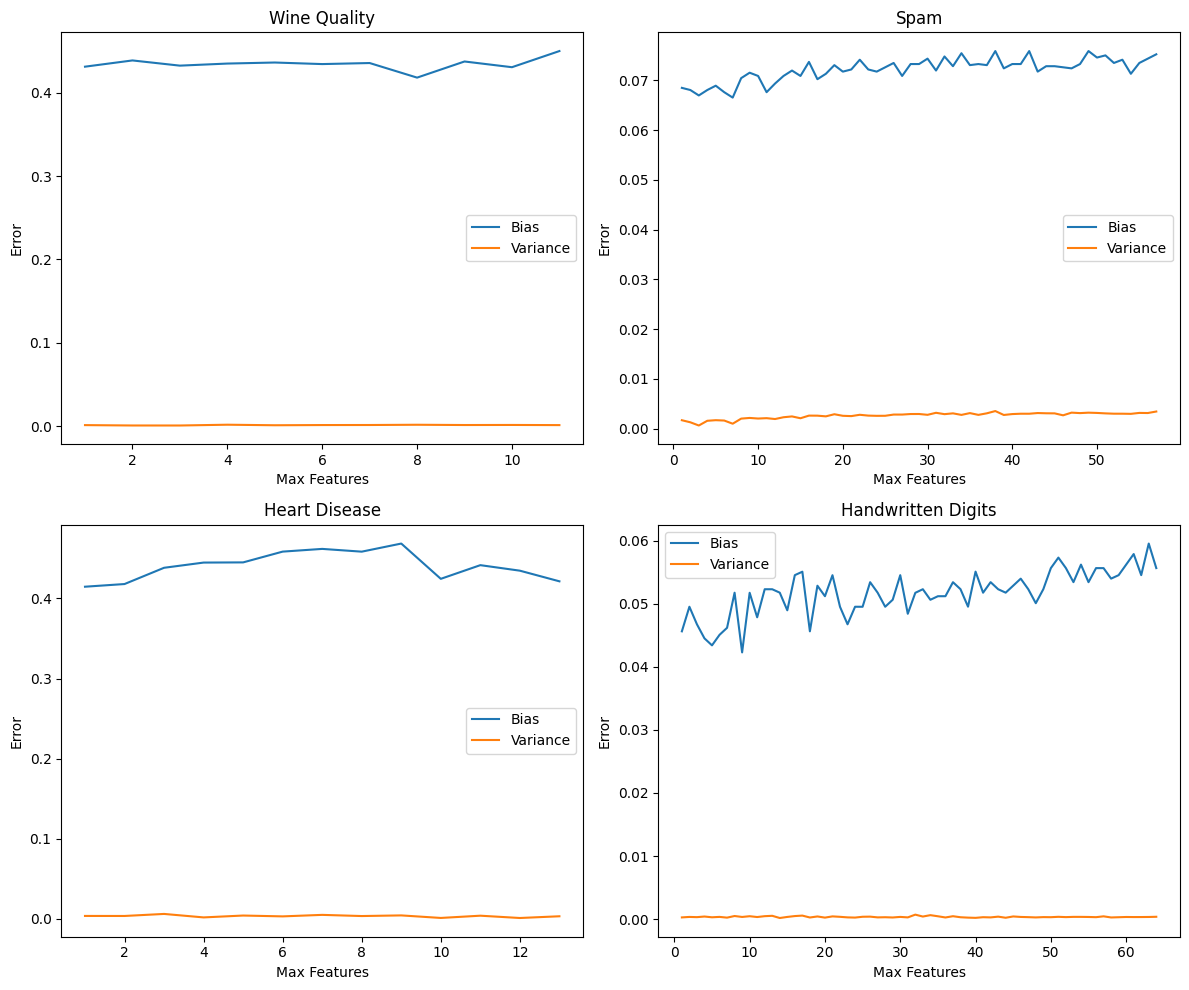

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

def bias_variance_tradeoff_max_features(X, y, max_features):
    model = ExtraTreesClassifier(n_estimators=100, max_features=max_features, random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    bias = 1 - np.mean(scores)
    variance = np.var(scores)
    return max_features, bias, variance

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.ravel()

for i, (name, data) in enumerate(datasets_class.items()):
    X, y = data
    biases = []
    variances = []
    max_features_range = range(1, X.shape[1] + 1)

    ax[i].plot(max_features_range, biases, label='Bias')
    ax[i].plot(max_features_range, variances, label='Variance')
    ax[i].set_title(name)
    ax[i].set_xlabel('Max Features')
    ax[i].set_ylabel('Error')
    ax[i].legend()

plt.tight_layout()
plt.show()